In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

Files already downloaded and verified
Files already downloaded and verified


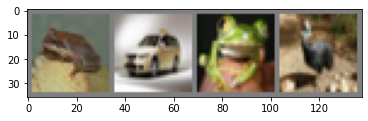

In [2]:
# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:
#Model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #16 * 5 * 5 is to flatten the volume before feeding it to the FC layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

test = {}
for name, param in model.named_parameters():
    test[name.split(".")[0]] = []
print(test)

{'conv1': [], 'conv2': [], 'fc1': [], 'fc2': [], 'fc3': []}


In [73]:
grads = {'conv1':[],'conv2':[],'fc1':[],'fc2':[],'fc3':[]}
#Training
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #Collect grads every epoch for plotting
        if i % n_total_steps == 0:
            print("Grads collected")
            grads['conv1'].append(np.copy(model.conv1.weight.grad.numpy()))
            grads['conv2'].append(np.copy(model.conv2.weight.grad.numpy()))
            grads['fc1'].append(np.copy(model.fc1.weight.grad.numpy()))
            grads['fc2'].append(np.copy(model.fc2.weight.grad.numpy()))
            grads['fc3'].append(np.copy(model.fc3.weight.grad.numpy()))
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Grads collected
Epoch [1/5], Step [2000/12500], Loss: 2.2609
Epoch [1/5], Step [4000/12500], Loss: 2.3001
Epoch [1/5], Step [6000/12500], Loss: 2.3099
Epoch [1/5], Step [8000/12500], Loss: 2.2052
Epoch [1/5], Step [10000/12500], Loss: 1.9610
Epoch [1/5], Step [12000/12500], Loss: 1.9535
Grads collected
Epoch [2/5], Step [2000/12500], Loss: 2.3150
Epoch [2/5], Step [4000/12500], Loss: 2.7174
Epoch [2/5], Step [6000/12500], Loss: 2.0885
Epoch [2/5], Step [8000/12500], Loss: 1.4978
Epoch [2/5], Step [10000/12500], Loss: 1.9045
Epoch [2/5], Step [12000/12500], Loss: 1.7446
Grads collected
Epoch [3/5], Step [2000/12500], Loss: 2.0002
Epoch [3/5], Step [4000/12500], Loss: 1.6305
Epoch [3/5], Step [6000/12500], Loss: 2.0863
Epoch [3/5], Step [8000/12500], Loss: 1.0797
Epoch [3/5], Step [10000/12500], Loss: 2.2800
Epoch [3/5], Step [12000/12500], Loss: 1.7988
Grads collected
Epoch [4/5], Step [2000/12500], Loss: 1.3994
Epoch [4/5], Step [4000/12500], Loss: 1.1698
Epoch [4/5], Step [6000/12500]

conv1


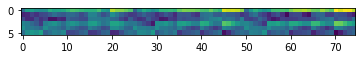

Mean Euclidian dist: 0.1961 	Mean Cosine sim: 0.0014


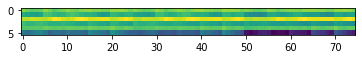

Mean Euclidian dist: 0.4362 	Mean Cosine sim: -0.0033


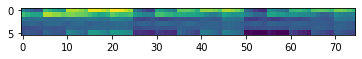

Mean Euclidian dist: 1.8692 	Mean Cosine sim: 0.0241


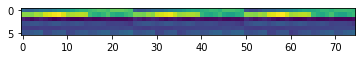

Mean Euclidian dist: 1.7475 	Mean Cosine sim: 0.0224


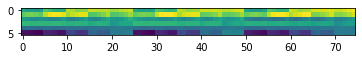

conv2


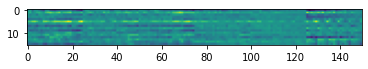

Mean Euclidian dist: 0.1384 	Mean Cosine sim: 0.0035


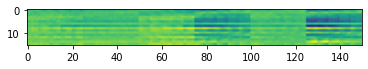

Mean Euclidian dist: 0.3196 	Mean Cosine sim: 0.0101


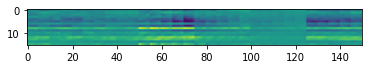

Mean Euclidian dist: 1.1089 	Mean Cosine sim: 0.0165


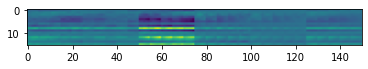

Mean Euclidian dist: 1.2947 	Mean Cosine sim: 0.0087


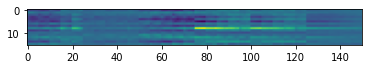

fc1


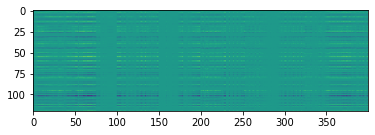

Mean Euclidian dist: 0.0963 	Mean Cosine sim: 0.1062


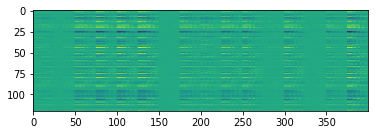

Mean Euclidian dist: 0.1975 	Mean Cosine sim: 0.2471


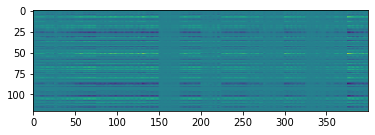

Mean Euclidian dist: 0.4637 	Mean Cosine sim: 0.2478


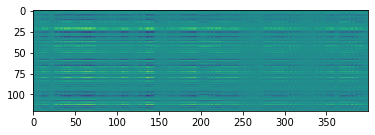

Mean Euclidian dist: 0.6653 	Mean Cosine sim: 0.0991


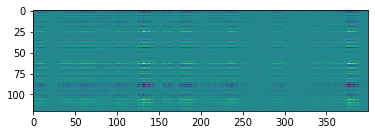

fc2


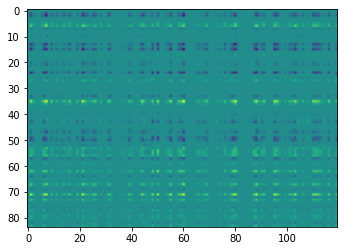

Mean Euclidian dist: 0.1018 	Mean Cosine sim: 0.0821


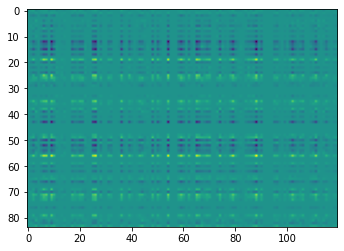

Mean Euclidian dist: 0.1965 	Mean Cosine sim: 0.2414


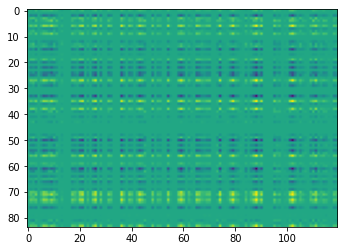

Mean Euclidian dist: 0.3427 	Mean Cosine sim: 0.1971


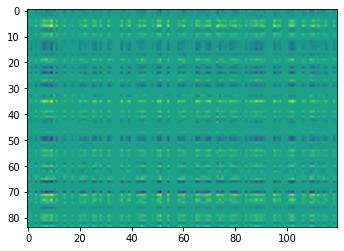

Mean Euclidian dist: 0.5259 	Mean Cosine sim: -0.0875


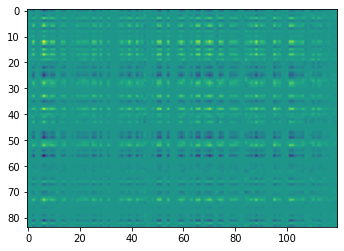

fc3


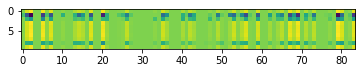

Mean Euclidian dist: 0.4497 	Mean Cosine sim: 0.2075


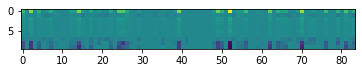

Mean Euclidian dist: 0.6148 	Mean Cosine sim: 0.5326


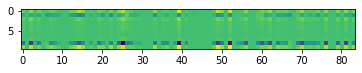

Mean Euclidian dist: 1.0973 	Mean Cosine sim: 0.3496


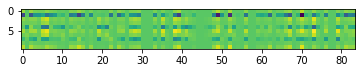

Mean Euclidian dist: 1.4166 	Mean Cosine sim: 0.1115


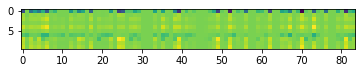

In [176]:
#Plot gradients
prev = np.copy(grads[layer][0])

#Test with conv1 grads
for name,grad_all_epoch in grads.items():
    print (name)
    for i in range(len(grad_all_epoch)):
        grad = grad_all_epoch[i]

        if i > 0:
            all_dist = []
            all_cos_sim = []
            for i in range(grad.shape[0]):
                dist = np.linalg.norm(grad[i] - prev[i])
                norm_product = np.linalg.norm(grad[i]) * np.linalg.norm(prev[i])
                cos_sim = np.dot(grad[i], prev[i])/ (norm_product) if norm_product != 0 else 0
                dot = np.dot(grad[i], prev[i])
                all_dist.append(dist)
                all_cos_sim.append(cos_sim)
                #print(f'Euclidian dist: {dist:.4f} \tCosine sim: {cos_sim:.4f}\t Dot: {dot}')
            print(f'Mean Euclidian dist: {np.mean(np.array(all_dist)):.4f} \tMean Cosine sim: {np.mean(np.array(all_cos_sim)):.4f}')

        prev = np.copy(grad)

        v1 = np.copy(grad)
        #Reshape conv layer gradients for visualization
        if len(v1.shape) == 4: #Flatten gradients of a conv layer
            v1 = v1.reshape((v1.shape[0],v1.shape[1] * v1.shape[2] * v1.shape[3]))
        plt.imshow(v1)
        plt.show()
    



In [136]:
a = np.array([-3,-3])
b = np.array([3,3])
cos_sim = np.dot(a, b)/ (np.linalg.norm(a) * np.linalg.norm(b))
cos_sim

-1.0000000000000002